This notebook generates plots for Gaussian Process Regression (GPR) for one dimension data. 
The code refers [Sklearn library](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x) - 0.8 * (x -2.5)
    

In [2]:
def gpr_plot(X, y, x, title = 'GPR'):

    # Instantiate a Gaussian Process model
    # kernel = C(1.0, (1e-3, 1e3)) * RBF(0.6, (1e-2, 1e2))
    kernel = C(3.5) * RBF(1)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.05,
                                  n_restarts_optimizer=0,#)
                                 optimizer=None)
    
    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)
    print(gp.kernel_)

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(x, return_std=True)

    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    plt.figure()
    plt.plot(x, f(x), 'g:', label='True function')
    if y.shape[0] > 4: 
        plt.plot(X[:4,], y[:4], 'g.', markersize=10, label='Observations')
        plt.plot(X[4:,], y[4:], 'r.', markersize=10, label='Recommendation')
    else:
        plt.plot(X, y, 'g.', markersize=10, label='Observations')
    plt.plot(x, y_pred, '-', label='Prediction')
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.3, ec='None', label='confidence interval')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim(-15, 20)
    plt.legend(loc='upper left')
    plt.title(title)
    
    return y_pred, sigma

In [3]:
x_test = np.atleast_2d(np.linspace(0, 10, 101)).T
x_test.reshape(-1,)[::5]

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

1.87**2 * RBF(length_scale=1)
1.87**2 * RBF(length_scale=1)
1.87**2 * RBF(length_scale=1)


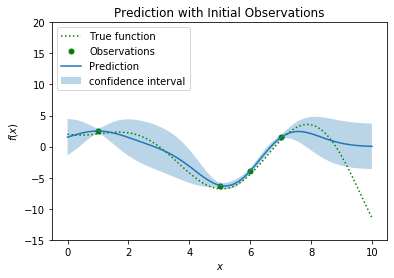

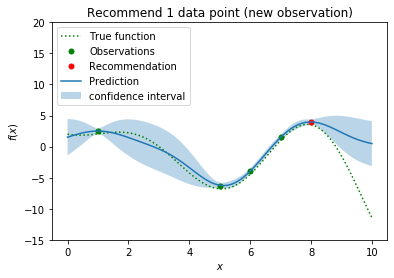

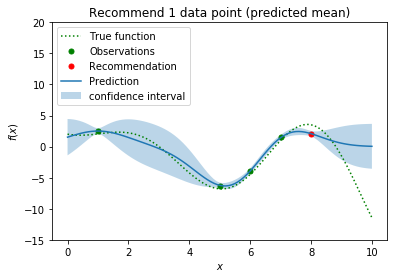

In [6]:
x_test = np.atleast_2d(np.linspace(0, 10, 101)).T
design_dist = 5
x_design = x_test.reshape(-1,)[::design_dist]
noise = 0.5

# init
X = np.atleast_2d([1., 5., 6., 7.]).T
# Observations
y = f(X).ravel() + noise

y_pred, sigma = gpr_plot(X,y, x_test, 'Prediction with Initial Observations')
#-------------------------------------------------------

# rec max ucb
rec_idx = np.argmax(y_pred[::design_dist] + 1.9600 * sigma[::design_dist])
rec = x_design[rec_idx]

obs_y = f(rec)+ 0.5
new_y = np.append(y, obs_y)

new_X = np.append(X.reshape(-1,), rec).reshape(-1,1)

new_pred, new_sigma = gpr_plot(new_X,new_y,x_test, 'Recommend 1 data point (new observation)')

#------------------------------------------------------
# rec max ucb, batch

obs_y = y_pred[::design_dist][rec_idx] 
batch_new_y = np.append(y, obs_y)

batch_new_pred, batch_new_sigma = gpr_plot(new_X,batch_new_y,x_test, 'Recommend 1 data point (predicted mean)')

The above plots show:  
The Gaussian Process Regression (GPR) predicts the mean with confidence interval which specified by the predicted variance. 
We assume the observations are noisy, so even when a data pointed in observed then confidence interval is stil bigger than 0. 
The first plot shows the prediction with 4 initial observations. The design (recommendation) space is 20 uniformly distributed points in the range [0,10], i.e. {0, 0.5, 1, 1.5 , ..., 9.5, 10}.  
The second and third plots show the prediction with one more recommended point. The second one is with the true observation of the recommended point. The third one is with the predicted value of the recommended point.  
By comparing the last two plots, we illustrate that whether observing the true of the recommended point does not influence the predicted variance. 

1.87**2 * RBF(length_scale=1)
1.87**2 * RBF(length_scale=1)


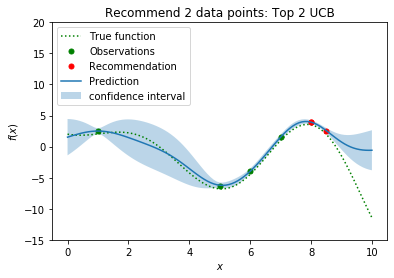

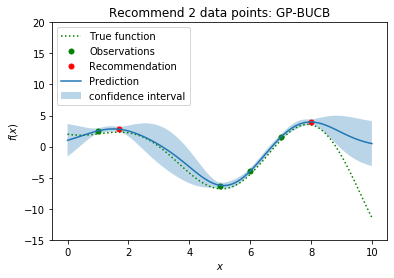

In [7]:
# rec 2 points
round6_rec_idx = np.argsort(y_pred[::design_dist] + 1.9600 * sigma[::design_dist])[-2:]
rec = x_design[round6_rec_idx]

obs_y = f(rec)+ 0.5
round6_new_y = np.append(new_y, obs_y)

round6_new_X = np.append(new_X.reshape(-1,), rec).reshape(-1,1)

new_pred, new_sigma = gpr_plot(round6_new_X,round6_new_y,x_test, 'Recommend 2 data points: Top 2 UCB')

# rec for round 6
batch6_rec_idx = np.argmax(new_pred + 1.9600 * new_sigma)
rec = x_test[round6_rec_idx][0]

obs_y = f(rec)+ 0.5
batch6_new_y = np.append(new_y, obs_y)

batch6_new_X = np.append(new_X.reshape(-1,), rec).reshape(-1,1)

new_pred, new_sigma = gpr_plot(batch6_new_X, batch6_new_y,x_test, 'Recommend 2 data points: GP-BUCB')

Now we show the case for batch recommendations, i.e. recommend more then one data point at one time.  
The first plot shows we recommend two data points for the top ucb of the predictions based on the 4 initial observations.  
The second plot shows we recommend two data points using GP-BUCB approaches, i.e. taking into account the similarity between recommendations.   
In this example, the GP-BUCB recommends the second points by assuming that we have observed the first recommend data point (x=8), then the predicted variance of data points around x = 8 becomes smaller compared when we do not assume observing that point. So instead of recommending x = 0.85, the GP-BUCB recommends x = 2, which gives us the chance to explore another potential local optima. 